In [3]:
import pandas as pd
import yfinance as yf

#baixa dados de 2020 até hoje para ML e estatísticos
btc = yf.download('BTC-USD', start='2020-01-01')

#reseta índice para ter coluna Date
btc = btc.reset_index()

#mantem apenas colunas relevantes
btc = btc[['Date', 'Close', 'Volume']].dropna()
btc.head()


C:\Users\guiga\AppData\Local\Temp\ipykernel_19860\1480854941.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2020-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,Volume
Ticker,,BTC-USD,BTC-USD
0,2020-01-01,7200.174316,18565664997
1,2020-01-02,6985.470215,20802083465
2,2020-01-03,7344.884277,28111481032
3,2020-01-04,7410.656738,18444271275
4,2020-01-05,7411.317383,19725074095


In [4]:
#cria colunas defasadas
btc['Close_lag1'] = btc['Close'].shift(1)
btc['Close_lag7'] = btc['Close'].shift(7)

#cria retornos percentuais
btc['Return_1d'] = btc['Close'].pct_change()
btc['Return_7d'] = btc['Close'].pct_change(7)

#remove valores nulos
btc = btc.dropna()
btc.head()


Price,Date,Close,Volume,Close_lag1,Close_lag7,Return_1d,Return_7d
Ticker,,BTC-USD,BTC-USD,,,,
7,2020-01-08,8079.862793,31672559265,8163.692383,7200.174316,-0.010269,0.122176
8,2020-01-09,7879.071289,24045990466,8079.862793,6985.470215,-0.024851,0.127923
9,2020-01-10,8166.554199,28714583844,7879.071289,7344.884277,0.036487,0.111870
10,2020-01-11,8037.537598,25521165085,8166.554199,7410.656738,-0.015798,0.084592
11,2020-01-12,8192.494141,22903438381,8037.537598,7411.317383,0.019279,0.105403


In [5]:
from sklearn.model_selection import train_test_split

X = btc[['Close_lag1', 'Close_lag7', 'Return_1d', 'Return_7d']]
y = btc['Close']

#split temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [6]:
from statsmodels.tsa.arima.model import ARIMA

#usa apenas o preço para ARIMA
btc_arima = btc.set_index('Date')['Close']

#treino e teste
train_size = int(len(btc_arima) * 0.8)
train, test = btc_arima.iloc[:train_size], btc_arima.iloc[train_size:]

#modelo ARIMA simples
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

#previsão
forecast = model_fit.forecast(steps=len(test))


C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [7]:
from sklearn.linear_model import LinearRegression

#instanceia e treina
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

#previsão
y_pred_lr = model_lr.predict(X_test)


In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

#função para MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#ARIMA
mae_arima = mean_absolute_error(test, forecast)
rmse_arima = np.sqrt(mean_squared_error(test, forecast))
mape_arima = mape(test, forecast)

#regressão linear
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mape_lr = mape(y_test, y_pred_lr)

#naive
y_naive = X_test['Close_lag1']
mae_naive = mean_absolute_error(y_test, y_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))
mape_naive = mape(y_test, y_naive)

print('ARIMA → MAE:', mae_arima, '| RMSE:', rmse_arima, '| MAPE:', mape_arima)
print('Linear Regression → MAE:', mae_lr, '| RMSE:', rmse_lr, '| MAPE:', mape_lr)
print('Naive Forecast → MAE:', mae_naive, '| RMSE:', rmse_naive, '| MAPE:', mape_naive)


ARIMA → MAE: 26436.62118429271 | RMSE: 31251.309820024715 | MAPE: nan
Linear Regression → MAE: 956.1285327265622 | RMSE: 1342.1510340629477 | MAPE: 1.0676137771322531
Naive Forecast → MAE: 1508.0555555555557 | RMSE: 2094.777867776132 | MAPE: nan


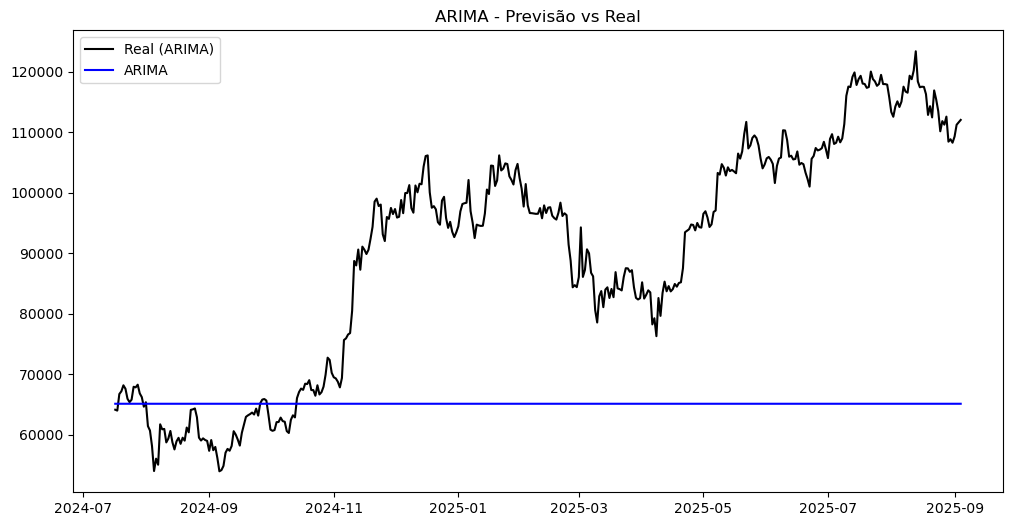

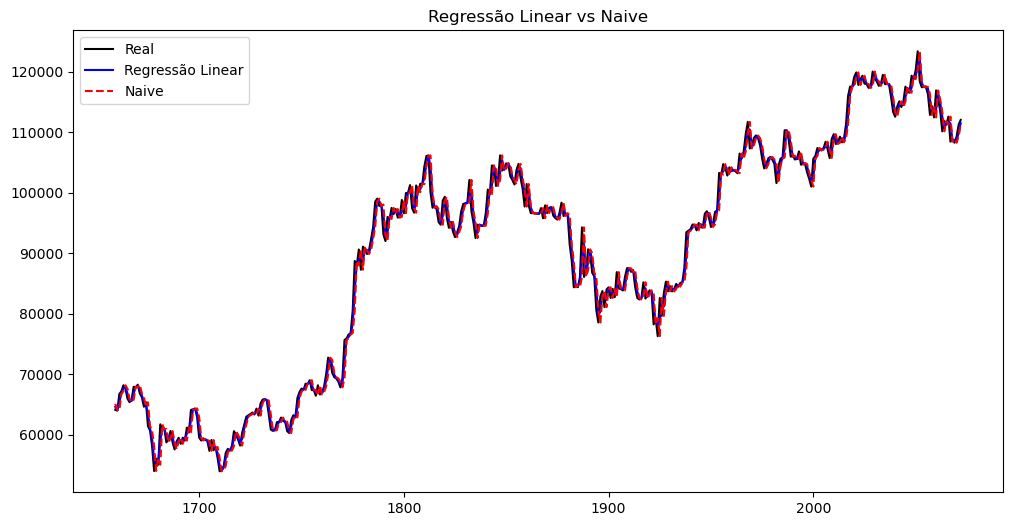

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, label='Real (ARIMA)', color='black')
plt.plot(test.index, forecast, label='ARIMA', color='blue')
plt.legend()
plt.title('ARIMA - Previsão vs Real')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Real', color='black')
plt.plot(y_test.index, y_pred_lr, label='Regressão Linear', color='blue')
plt.plot(y_test.index, y_naive, label='Naive', color='red', linestyle='--')
plt.legend()
plt.title('Regressão Linear vs Naive')
plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.set_index('Date')

#divisão treino/teste
train_size = int(len(btc) * 0.8)
train, test = btc['Close'][:train_size], btc['Close'][train_size:]


KeyError: 'Date'

In [12]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
forecast_direct = model_fit.forecast(steps=len(test))


C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\guiga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [13]:
history = list(train)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

forecast_rolling = pd.Series(predictions, index=test.index)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [14]:
from statsmodels.tsa.arima.model import ARIMA

#garante que 'Close' é numérico
btc['Close'] = pd.to_numeric(btc['Close'], errors='coerce')

#remove valores NaN
btc = btc.dropna()

#historico
train = btc['Close'][:'2023']
test  = btc['Close']['2024':]

history = list(train)

predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]   #previsão
    predictions.append(yhat)
    history.append(test.iloc[t])     #adiciona o valor real


TypeError: arg must be a list, tuple, 1-d array, or Series

In [15]:
print(type(btc))
print(btc.head())


<class 'pandas.core.frame.DataFrame'>
Price             Close       Volume   Close_lag1   Close_lag7 Return_1d  \
Ticker          BTC-USD      BTC-USD                                       
Date                                                                       
2020-01-08  8079.862793  31672559265  8163.692383  7200.174316 -0.010269   
2020-01-09  7879.071289  24045990466  8079.862793  6985.470215 -0.024851   
2020-01-10  8166.554199  28714583844  7879.071289  7344.884277  0.036487   
2020-01-11  8037.537598  25521165085  8166.554199  7410.656738 -0.015798   
2020-01-12  8192.494141  22903438381  8037.537598  7411.317383  0.019279   

Price      Return_7d  
Ticker                
Date                  
2020-01-08  0.122176  
2020-01-09  0.127923  
2020-01-10  0.111870  
2020-01-11  0.084592  
2020-01-12  0.105403  


In [16]:
print(btc.columns)


MultiIndex([(     'Close', 'BTC-USD'),
            (    'Volume', 'BTC-USD'),
            ('Close_lag1',        ''),
            ('Close_lag7',        ''),
            ( 'Return_1d',        ''),
            ( 'Return_7d',        '')],
           names=['Price', 'Ticker'])


In [17]:
#garante que btc é DataFrame
if not isinstance(btc, pd.DataFrame):
    btc = pd.DataFrame(btc)

#mostra colunas disponíveis
print('Colunas disponíveis:', btc.columns)

if 'Close' in btc.columns:
    btc['Close'] = pd.to_numeric(btc['Close'], errors='coerce')
    btc = btc.dropna(subset=['Close'])
else:
    raise ValueError('Coluna Close não encontrada no DataFrame')


Colunas disponíveis: MultiIndex([(     'Close', 'BTC-USD'),
            (    'Volume', 'BTC-USD'),
            ('Close_lag1',        ''),
            ('Close_lag7',        ''),
            ( 'Return_1d',        ''),
            ( 'Return_7d',        '')],
           names=['Price', 'Ticker'])


TypeError: arg must be a list, tuple, 1-d array, or Series

In [19]:
print(btc.head())
print(btc.columns)

Price             Close       Volume   Close_lag1   Close_lag7 Return_1d  \
Ticker          BTC-USD      BTC-USD                                       
Date                                                                       
2020-01-08  8079.862793  31672559265  8163.692383  7200.174316 -0.010269   
2020-01-09  7879.071289  24045990466  8079.862793  6985.470215 -0.024851   
2020-01-10  8166.554199  28714583844  7879.071289  7344.884277  0.036487   
2020-01-11  8037.537598  25521165085  8166.554199  7410.656738 -0.015798   
2020-01-12  8192.494141  22903438381  8037.537598  7411.317383  0.019279   

Price      Return_7d  
Ticker                
Date                  
2020-01-08  0.122176  
2020-01-09  0.127923  
2020-01-10  0.111870  
2020-01-11  0.084592  
2020-01-12  0.105403  
MultiIndex([(     'Close', 'BTC-USD'),
            (    'Volume', 'BTC-USD'),
            ('Close_lag1',        ''),
            ('Close_lag7',        ''),
            ( 'Return_1d',        ''),
            

In [20]:
#achata as colunas para nomes simples
btc.columns = [col[0] if col[1] == '' else f'{col[0]}_{col[1]}' for col in btc.columns]

print(btc.head())
print(btc.columns)


            Close_BTC-USD  Volume_BTC-USD   Close_lag1   Close_lag7  \
Date                                                                  
2020-01-08    8079.862793     31672559265  8163.692383  7200.174316   
2020-01-09    7879.071289     24045990466  8079.862793  6985.470215   
2020-01-10    8166.554199     28714583844  7879.071289  7344.884277   
2020-01-11    8037.537598     25521165085  8166.554199  7410.656738   
2020-01-12    8192.494141     22903438381  8037.537598  7411.317383   

            Return_1d  Return_7d  
Date                              
2020-01-08  -0.010269   0.122176  
2020-01-09  -0.024851   0.127923  
2020-01-10   0.036487   0.111870  
2020-01-11  -0.015798   0.084592  
2020-01-12   0.019279   0.105403  
Index(['Close_BTC-USD', 'Volume_BTC-USD', 'Close_lag1', 'Close_lag7',
       'Return_1d', 'Return_7d'],
      dtype='object')


In [21]:
btc['Close_BTC-USD'] = pd.to_numeric(btc['Close_BTC-USD'], errors='coerce')
btc = btc.dropna(subset=['Close_BTC-USD'])


In [22]:
history = list(train)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

forecast_rolling = pd.Series(predictions, index=test.index)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [23]:
#garante que 'Close' seja numérico
btc['Close_BTC-USD'] = pd.to_numeric(btc['Close_BTC-USD'], errors='coerce')
btc = btc.dropna(subset=['Close_BTC-USD'])

#conjunto treino/teste
train_size = int(len(btc) * 0.8)
train, test = btc['Close_BTC-USD'].iloc[:train_size], btc['Close_BTC-USD'].iloc[train_size:]

#history deve começar como lista de floats
history = list(train.values)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]   #previsão
    predictions.append(yhat)
    history.append(test.iloc[t])     #adiciona o valor real ao histórico


In [ ]:
plt.figure(figsize=(12,6))

#ultimos 365 dias
zoom_start = test.index[-365]

plt.plot(train[zoom_start:], label='Treino')
plt.plot(test[zoom_start:], label='Real')
plt.plot(forecast_direct[zoom_start:], label='ARIMA Direto (reta)')
plt.plot(forecast_rolling[zoom_start:], label='ARIMA Rolling (dinâmico)')

plt.title("Previsão ARIMA - Últimos 12 meses")
plt.xlabel("Data")
plt.ylabel("Preço BTC (USD)")
plt.legend()
plt.show()


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("ARIMA Direto - MAE:", mean_absolute_error(test, forecast_direct))
print("ARIMA Direto - RMSE:", rmse(test, forecast_direct))

print("ARIMA Rolling - MAE:", mean_absolute_error(test, forecast_rolling))
print("ARIMA Rolling - RMSE:", rmse(test, forecast_rolling))


ARIMA Direto - MAE: 26436.62118429271
ARIMA Direto - RMSE: 31251.309820024715


NameError: name 'forecast_rolling' is not defined

In [26]:
history = list(train)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

forecast_rolling = pd.Series(predictions, index=test.index)


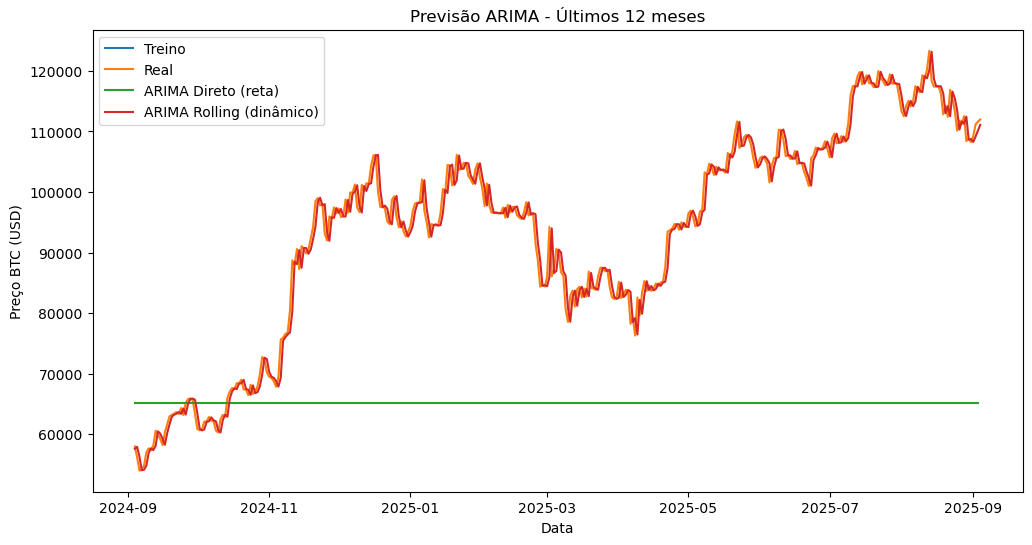

In [28]:
plt.figure(figsize=(12,6))

zoom_start = test.index[-365]

plt.plot(train[zoom_start:], label='Treino')
plt.plot(test[zoom_start:], label='Real')
plt.plot(forecast_direct[zoom_start:], label='ARIMA Direto (reta)')
plt.plot(forecast_rolling[zoom_start:], label='ARIMA Rolling (dinâmico)')

plt.title("Previsão ARIMA - Últimos 12 meses")
plt.xlabel("Data")
plt.ylabel("Preço BTC (USD)")
plt.legend()
plt.show()


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("ARIMA Direto - MAE:", mean_absolute_error(test, forecast_direct))
print("ARIMA Direto - RMSE:", rmse(test, forecast_direct))

print("ARIMA Rolling - MAE:", mean_absolute_error(test, forecast_rolling))
print("ARIMA Rolling - RMSE:", rmse(test, forecast_rolling))


ARIMA Direto - MAE: 26436.62118429271
ARIMA Direto - RMSE: 31251.309820024715
ARIMA Rolling - MAE: 1505.3499142007715
ARIMA Rolling - RMSE: 2092.6492388043816
